# Competition 1 Notebook

In this notebook, we have all of our code for Competition 1. Each Part of this notebook is broken out into parts so that it is understandable of the approach that we took to create our model. The goal of this Competition was to understand IPO's of Companies using the Pre IPO Price Revision (Y1) and the Post IPO Initial Return (Y2). More detials about our pipeline can be found in our [README.MD](README.md) file.

## Importing Required Packages

These are the packages that we will use in our project. 

In [1]:
#importing required libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backend as bk
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from pandas import ExcelWriter
from sklearn import preprocessing
from sklearn.decomposition import PCA

#set plot style to 'ggplot' and don't limit the view of DF when diaplyhign them to screen
plt.style.use('ggplot')
pd.options.display.max_columns = None

## Import File and Reset Index

Here we are importing our actual data file `Competition1_raw_data.xlsx` where we identify `na_values` as '-' and we also reset our index so that our index is company stock symbols. We then verify that everything was imported correctly.

In [2]:
#importing our data and resetting our index
df = pd.read_excel('Competition1_raw_data.xlsx', na_values='-')
df.set_index('I1', inplace=True)
df.head(1)

,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
I1,,,,,,,,,,,,,,,,,,,,,
AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.87,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0


## Changing DataTypes

In this block, we are going to set all our predictor values to `float` data types so that we can run various calculations on it. We then verify that our data types are all correct. 

In [3]:
#convert data types of our columns to float
to_float = ['I3','P(IPO)','P(H)', 'P(L)', 'P(1Day)', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3']

for col in to_float:
    df[col]=pd.to_numeric(df[col], errors='coerce')
df.dtypes

I2          object
I3         float64
P(IPO)     float64
P(H)       float64
P(L)       float64
P(1Day)    float64
C1         float64
C2         float64
C3         float64
C4         float64
C5         float64
C6         float64
C7         float64
T1         float64
T2         float64
T3         float64
T4         float64
T5         float64
S1         float64
S2         float64
S3         float64
dtype: object

## EDA on Our Data

We want a better understanding of our dataset. So we ran some code to see if our columns were 'normal' or not. We can see that it is sort of hard to see the histograms below, so we also ran a skewness check below to see how skewed our data was. While we do run it on all columns, we really only looked at the continous ones.

In [4]:
df.describe()

,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
count,670.000000,677.000000,672.000000,672.000000,660.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000
mean,6439.086567,13.837666,15.481190,13.515045,25.934766,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.634361,12758.606461,11395.844347,294.353891,679.220264,68.421439,120.104258,144.759178
std,29398.570586,6.053731,6.653429,5.835646,73.234948,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.741647,5449.644597,4839.670179,121.532637,472.914323,39.096525,84.828959,69.276285
min,100.000000,3.000000,0.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,26.000000
25%,3110.000000,10.000000,12.500000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.000000,9195.000000,8162.000000,213.000000,462.000000,45.000000,73.000000,100.000000
50%,3845.000000,13.500000,15.000000,13.000000,14.845000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.000000,12045.000000,10785.000000,279.000000,624.000000,60.000000,100.000000,134.000000
75%,7371.000000,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.000000,15241.000000,13760.000000,354.000000,795.000000,85.000000,142.000000,173.000000
max,541990.000000,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.000000,1058.000000,10277.000000,309.000000,944.000000,883.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f183f22c828>,
      dtype=object)

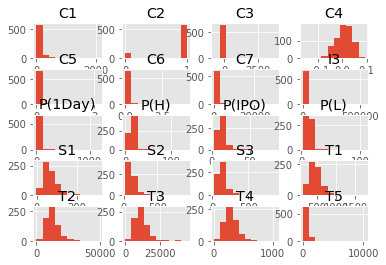

In [5]:
#visually try to check skewness
df.hist()

In [6]:
#check skewness
df.skew()

I3         18.126113
P(IPO)      3.390065
P(H)        9.215324
P(L)        7.106899
P(1Day)    12.318970
C1          5.649485
C2         -2.068874
C3         20.593747
C4         -0.477892
C5         13.601573
C6         12.559330
C7         11.714131
T1          1.739135
T2          1.638533
T3          1.616041
T4          1.419060
T5         12.762933
S1          2.310386
S2          3.734571
S3          3.437272
dtype: float64

## Cleanining and Imputing our Data

We want to check our data source. We want to see what columns have missing as well as how many. Once we do this, we will impute our missing data. We do this in parts so that our data retains as much intergity as possible. 

In [7]:
#check how many missing values we have for each column
df.isna().sum()

I2          0
I3         12
P(IPO)      5
P(H)       10
P(L)       10
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          1
T2          1
T3          1
T4          1
T5          1
S1          1
S2          1
S3          1
dtype: int64

Since we have some missing values, we have to adress these. First, we need to drop all the missing rows that are missing P(1Day) becasue this will be used for our predictor variable, hence we are unable to impute that missing data. Next, we need to create our target variables and other predicotr variables we would like to include.

In [8]:
#dropping our P(1Day) values that have missing data
df = df.dropna(subset=['P(1Day)'])
## Creating Necessary Variables Y1, Y2, C3', C5', and C6'
df['P(Mid)'] = (df['P(H)'] + df['P(L)']) / 2
df['Y1'] = np.where(df['P(IPO)'] < df['P(Mid)'], 1,0)
df['Y2'] = np.where(df['P(IPO)'] < df['P(1Day)'], 1,0)
df["C3_Prime"] = np.where(df['C3'] > 0, 1, 0)
df["C5_Prime"] = df['C5'] / df['C6']
df["C6_Prime"] = np.where(df['P(IPO)'] > df['P(Mid)'], ((df['P(IPO)'] - df['P(Mid)']) / df['P(Mid)']) * 100,0)

We want to seperate our Y1 and Y2 predicotr vriables and keep them in thier own dataframes for the time being. This way, we don't accidently normazlie or standardize our Y columns

In [9]:
#just saving our Y1 and Y2 values into thier own dataframes
df_y1 = df['Y1']
df_y2= df['Y2']

Now we want to convert our I3 columns into thier respective SEC SIC codes found on [the SEC Website](https://www.sec.gov/info/edgar/siccodes.htm) website. We do this actual code in the `backend.py` file to save some space and make things prettier for our notebook. We then get a count of our industry values.

In [10]:
#assign a text based value to our industries
df['industry'] = df['I3'].apply(bk.assign_sector)
df['industry'].value_counts()

Manufacturing                              296
Services                                   200
Transportation/Communications/Utulities     58
Retail Trade                                48
Mining                                      31
Wholesale Trade                             13
Finance/Insurance/Realestate                 5
Non Classafiable Establishments              2
Agriculture/Forestry/Fishing                 2
Construction                                 1
Name: industry, dtype: int64

We now want to convert our categorical variables into continous, anf then bin them so that we reduce our number of features. We bin 'Manufacturing' and 'Services' into thier own columns (industry_1 and industry_2 respectively) and group all the other industries into one bin industry_3

In [11]:
#bin all of our other values into 'other'
df['industry'] = df['industry'].replace(['Transportation/Communications/Utulities','Retail Trade','Mining', 'Wholesale Trade', 'Finance/Insurance/Realestate', 'Non Classafiable Establishments',
                                            'Agriculture/Forestry/Fishing', 'Construction', 'NaN'],'Other')

#convert from categorical to continous
df['industry'] = df['industry'].replace({'Manufacturing': 1, 'Services': 2, 'Other': 3})
df['industry_1'] = np.where(df['industry'] ==1, 1, 0)
df['industry_2'] = np.where(df['industry'] ==2, 1, 0)
df['industry_3'] = np.where(df['industry'] ==3, 1, 0)
df.head(10)

,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,P(Mid),Y1,Y2,C3_Prime,C5_Prime,C6_Prime,industry,industry_1,industry_2,industry_3
I1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674.0,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,9.0,0,1,1,3.864345,11.111111,1.0,1,0,0
ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834.0,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,9.0,1,0,0,12.028832,0.000000,1.0,1,0,0
ACAD,ACADIA PHARMACEUTICALS INC,2834.0,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,13.0,1,0,0,3.369134,0.000000,1.0,1,0,0
ACHN,ACHILLION PHARMACEUTICALS INC,2834.0,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,15.0,1,1,0,3.299697,0.000000,1.0,1,0,0
ACLI,AMERICAN COMMERCIAL LINES INC.,4492.0,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,20.0,0,1,1,3.726269,5.000000,3.0,0,0,1
ACOM,Ancestry.com Inc.,7379.0,13.5,14.5,12.5,14.200000,94.0,1.0,0.06,-0.057556,42402916.0,7407407.0,197.591,510.0,17999.0,13934.0,328.0,815.0,62.0,96.0,181.0,13.5,0,1,1,5.724394,0.000000,2.0,0,1,0
ACOR,ACORDA THERAPEUTICS INC,2836.0,6.0,13.0,11.0,6.720000,128.0,1.0,-1.87,0.004106,19047022.0,5500000.0,5.146,495.0,15758.0,13953.0,379.0,698.0,82.0,106.0,135.0,12.0,1,1,0,3.463095,0.000000,1.0,1,0,0
ACRX,ACELRX PHARMACEUTICALS INC,2834.0,5.0,14.0,12.0,4.550000,91.0,0.0,-0.74,0.040620,19371750.0,8000000.0,NaN,334.0,11226.0,10056.0,276.0,-1.0,55.0,120.0,122.0,13.0,1,0,0,2.421469,0.000000,1.0,1,0,0
ACTV,ACTIVE NETWORK INC,7372.0,15.0,18.0,16.0,15.900000,100.0,1.0,-0.51,-0.029316,52982501.0,11000000.0,279.600,620.0,14813.0,13463.0,335.0,917.0,58.0,124.0,234.0,17.0,1,1,0,4.816591,0.000000,2.0,0,1,0


## Now we need to create our ratio columns

Here we are converting our columns that are focused on Textual Charactersitics and Sentiment Charctersitics of the IPO Prospectus into ratio values rather than strictly raw count fields. 


In [12]:
#converting our columns into ratio values and making them as new columns
t2_mean = df['T2'].mean()
df['T2'] = np.where(df['T2'] ==0, t2_mean, df['T2'])
df["S1_Prime"]= df['S1']/df['T2']
df["S2_Prime"]= df['S2']/df['T2']
df["S3_Prime"]= df['S3']/df['T2']
df["T3_Prime"]= df['T3']/df['T2']
df["T4_Prime"]= df['T4']/df['T1']
df["T5_Prime"]= df['T5']/df['T2']

we also no longer need these two columns so we are going to just clean up our DF so that it is all numerica based values, not more text

In [13]:
df = df.drop(columns = ['I2', 'I3', 'industry'])
df.head()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,P(Mid),Y1,Y2,C3_Prime,C5_Prime,C6_Prime,industry_1,industry_2,industry_3,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime
I1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AATI,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,9.0,0,1,1,3.864345,11.111111,1,0,0,0.004875,0.009199,0.010929,0.908876,0.640426,0.054250
ABPI,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,9.0,1,0,0,12.028832,0.000000,1,0,0,0.003258,0.011105,0.010876,0.898724,0.644753,0.051395
ACAD,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,13.0,1,0,0,3.369134,0.000000,1,0,0,0.011593,0.006271,0.011403,0.909350,0.636816,0.061764
ACHN,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,15.0,1,1,0,3.299697,0.000000,1,0,0,0.009686,0.007144,0.013319,0.917060,0.539634,0.061630
ACLI,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,20.0,0,1,1,3.726269,5.000000,0,0,1,0.004518,0.010047,0.011261,0.888469,0.587413,0.048550


Some of our columns we have noticed (when we described them above) they have negative values or 0's for text based columns which is simply impossible. We want to fix these rows

In [14]:
#T3 need to get rid of thier zeros.
t3_mean = df['T3'].mean()
df['T3'] = np.where(df['T3'] ==0, t3_mean, df['T3'])
print(t3_mean)

#S1 need to get rid of thier negative ones.
s1_mean = df['S1'].mean()
df['S1'] = np.where(df['S1'] ==-1, s1_mean, df['S1'])
print(s1_mean)

#T5 need to get rid of thier negative ones.
t5_mean = df['T5'].mean()
df['T5'] = np.where(df['T5'] ==-1, s1_mean, df['T5'])
print(t5_mean)

11463.39393939394
68.67575757575757
669.8909090909091


We want to impute our missing values for our C7 and C3 columns, but since they are skewed we want to normalize them first before we impute our missing fields. We used the Log approach for C7 and the cuberoot approach for C3.

In [15]:
#nromalize qnd impute C7 values
df['C7'] = np.log(df['C7'])
c7_mean = df['C7'].mean()
print(c7_mean)
df['C7'] = df['C7'].fillna(c7_mean)

#normalize and impute C3 values
df['C3'] = np.cbrt(df['C3'])
c3_mean = df['C3'].mean()
print(c3_mean)
df['C3'] = df['C3'].fillna(c3_mean)

4.592588484196865
-0.21843318437028425


Now we can check our missing values to make sure that all of our data is ready for the next steps of the pipeline.

In [16]:
df.isna().sum()

P(IPO)        0
P(H)          0
P(L)          0
P(1Day)       0
C1            0
C2            0
C3            0
C4            0
C5            0
C6            0
C7            0
T1            0
T2            0
T3            0
T4            0
T5            0
S1            0
S2            0
S3            0
P(Mid)        0
Y1            0
Y2            0
C3_Prime      0
C5_Prime      0
C6_Prime      0
industry_1    0
industry_2    0
industry_3    0
S1_Prime      0
S2_Prime      0
S3_Prime      0
T3_Prime      0
T4_Prime      0
T5_Prime      0
dtype: int64

In [17]:
df.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,P(Mid),Y1,Y2,C3_Prime,C5_Prime,C6_Prime,industry_1,industry_2,industry_3,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,6.600000e+02,6.600000e+02,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,14.034621,15.610394,13.635394,25.934766,149.728788,0.859091,-0.218433,0.007282,4.996285e+07,1.258248e+07,4.592588,468.701515,12888.641524,11515.500275,295.957576,669.996478,68.781327,120.896970,145.516667,14.622894,0.500000,0.698485,0.477273,4.417255,5.404645,0.448485,0.303030,0.242424,0.005308,0.009055,0.011516,0.891504,0.626720,0.052171
std,5.954214,6.613816,5.790112,73.234948,152.817467,0.348192,1.534849,0.033318,1.055377e+08,2.539940e+07,1.916640,176.374430,5415.681452,4805.168278,122.172959,298.043412,39.316670,85.542267,69.824545,6.187137,0.500379,0.459264,0.499862,5.133537,10.877569,0.497716,0.459917,0.428875,0.001755,0.002990,0.002842,0.071672,0.077686,0.007347
min,5.000000,0.000000,5.000000,0.000000,10.000000,0.000000,-9.229642,-0.162352,3.693227e+06,8.000000e+05,-2.603690,132.000000,3271.000000,3003.000000,0.000000,68.675758,9.000000,20.000000,40.000000,4.000000,0.000000,0.000000,0.000000,0.283223,0.000000,0.000000,0.000000,0.000000,-0.000093,0.002152,0.005326,0.000000,0.000000,-0.000089
25%,10.000000,13.000000,11.000000,11.000000,85.000000,1.000000,-0.926368,-0.013927,1.877568e+07,5.124546e+06,3.724681,356.000000,9275.500000,8297.000000,214.000000,463.750000,45.000000,74.000000,100.000000,12.000000,0.000000,0.000000,0.000000,2.850622,0.000000,0.000000,0.000000,0.000000,0.004131,0.006966,0.009579,0.883417,0.580329,0.047544
50%,13.750000,15.500000,13.000000,14.845000,107.000000,1.000000,-0.218433,0.009125,2.745438e+07,7.500000e+06,4.592588,446.000000,12141.500000,10853.000000,280.000000,627.000000,60.000000,101.500000,135.000000,14.250000,0.500000,1.000000,0.000000,3.731035,0.000000,0.000000,0.000000,0.000000,0.005027,0.008577,0.011301,0.897294,0.628861,0.051927
75%,17.000000,17.000000,15.000000,20.485000,155.250000,1.000000,0.738329,0.031571,5.003986e+07,1.200000e+07,5.706326,553.250000,15275.000000,13793.500000,355.250000,801.250000,85.000000,144.000000,174.000000,16.000000,1.000000,1.000000,1.000000,4.857904,7.692308,1.000000,1.000000,0.000000,0.006254,0.010521,0.012848,0.909693,0.674461,0.056489
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,15.692704,0.092896,2.138085e+09,4.212336e+08,10.331464,1750.000000,49056.000000,43952.000000,1058.000000,2729.000000,309.000000,944.000000,883.000000,121.500000,1.000000,1.000000,1.000000,99.787255,100.000000,1.000000,1.000000,1.000000,0.012839,0.024605,0.029397,1.490540,0.826347,0.088329


## Normalization For Our Continous Variables

Here we will normalize and standardize our data to be used in our predictive modeling. 

In [18]:
#create a df to hold all our data, untouched so that we can add back our categorical variables after we are done normalizing and imputing
df_hold=df.copy()

Now we want to drop our columns from our dataset so that we don't mess up any of the data that we want to keep. We drop our categorical fields as well as the fields we used to create our target variables since they will be no use to us in our feature selection.

In [19]:
#drop columns that we don't want our preprocessing to effect
df = df.drop(columns = ['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)','P(Mid)','C2','C3_Prime', 'industry_1', 'industry_2', 'industry_3', 'Y1', 'Y2'])
df.head(1)

,C1,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,C5_Prime,C6_Prime,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime
I1,,,,,,,,,,,,,,,,,,,,,,
AATI,122.0,1.508104,0.029074,40962052.0,10600000.0,3.938568,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,3.864345,11.111111,0.004875,0.009199,0.010929,0.908876,0.640426,0.05425


Now are data is all set to be normalized and standradrzied. Lets see what it looks like before we do these steps

In [20]:
df.describe()

,C1,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,C5_Prime,C6_Prime,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime
count,660.000000,660.000000,660.000000,6.600000e+02,6.600000e+02,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,149.728788,-0.218433,0.007282,4.996285e+07,1.258248e+07,4.592588,468.701515,12888.641524,11515.500275,295.957576,669.996478,68.781327,120.896970,145.516667,4.417255,5.404645,0.005308,0.009055,0.011516,0.891504,0.626720,0.052171
std,152.817467,1.534849,0.033318,1.055377e+08,2.539940e+07,1.916640,176.374430,5415.681452,4805.168278,122.172959,298.043412,39.316670,85.542267,69.824545,5.133537,10.877569,0.001755,0.002990,0.002842,0.071672,0.077686,0.007347
min,10.000000,-9.229642,-0.162352,3.693227e+06,8.000000e+05,-2.603690,132.000000,3271.000000,3003.000000,0.000000,68.675758,9.000000,20.000000,40.000000,0.283223,0.000000,-0.000093,0.002152,0.005326,0.000000,0.000000,-0.000089
25%,85.000000,-0.926368,-0.013927,1.877568e+07,5.124546e+06,3.724681,356.000000,9275.500000,8297.000000,214.000000,463.750000,45.000000,74.000000,100.000000,2.850622,0.000000,0.004131,0.006966,0.009579,0.883417,0.580329,0.047544
50%,107.000000,-0.218433,0.009125,2.745438e+07,7.500000e+06,4.592588,446.000000,12141.500000,10853.000000,280.000000,627.000000,60.000000,101.500000,135.000000,3.731035,0.000000,0.005027,0.008577,0.011301,0.897294,0.628861,0.051927
75%,155.250000,0.738329,0.031571,5.003986e+07,1.200000e+07,5.706326,553.250000,15275.000000,13793.500000,355.250000,801.250000,85.000000,144.000000,174.000000,4.857904,7.692308,0.006254,0.010521,0.012848,0.909693,0.674461,0.056489
max,2087.000000,15.692704,0.092896,2.138085e+09,4.212336e+08,10.331464,1750.000000,49056.000000,43952.000000,1058.000000,2729.000000,309.000000,944.000000,883.000000,99.787255,100.000000,0.012839,0.024605,0.029397,1.490540,0.826347,0.088329


In [21]:
#check the starting skew values
df.skew()

C1           5.649485
C3           0.449573
C4          -0.477892
C5          13.461312
C6          12.439171
C7          -0.640945
T1           1.749729
T2           1.724285
T3           1.706574
T4           1.420226
T5           1.909239
S1           2.329712
S2           3.731903
S3           3.448485
C5_Prime    13.405536
C6_Prime     4.372685
S1_Prime     0.886520
S2_Prime     1.191917
S3_Prime     1.387090
T3_Prime    -7.335300
T4_Prime    -1.595377
T5_Prime    -0.143222
dtype: float64

Here, we are going to normalize our data using the Scikit-learn `normalize` function. We are using the L1 approach for this process because because we are trying to reduce the sum of absolute differences for normalization (also our model was better with L1 rather than L2). We also have to adjust C6 with `1/log` because the sckikt-learn normalize function wasn't quite strong enough to do the trick.

In [22]:
#normalize the data. We have to normalize C6 first for a little extra because of how skewed the data is. 
df['C6']=1/np.log(df['C6'])
df = pd.DataFrame(preprocessing.normalize(df,norm='l1'),columns = df.columns)
df.skew()

C1          7.037596
C3          0.000000
C4          0.000000
C5         -1.783382
C6          0.000000
C7          0.000000
T1          1.736257
T2          1.799540
T3          1.776145
T4          1.649230
T5          1.732126
S1          0.000000
S2          3.164735
S3          2.172741
C5_Prime    0.000000
C6_Prime    0.000000
S1_Prime    0.000000
S2_Prime    0.000000
S3_Prime    0.000000
T3_Prime    0.000000
T4_Prime    0.000000
T5_Prime    0.000000
dtype: float64

we can see that a lot of our data is now better, but not quite perfect. We use some more nromalization techniques to handle this issue below. We only run these computations on the columns we need to. 

In [23]:
#adjust skew for C1 with a strong adjustment
pos_skew = ['C1']

for col in pos_skew:
    df[col]=np.log(df[col])
    

#adjust skew for columns that only need a minor adjustment
over_log = ['T1', 'T2', 'T3', 'T5', 'S2', 'S3']
for col in over_log:
    df[col]=1/np.log(df[col])

#adjuts T4 with a minor adjustment
df['T4'] = np.sqrt(df['T4'])


In [24]:
df.skew()

C1         -0.408257
C3          0.000000
C4          0.000000
C5         -1.783382
C6          0.000000
C7          0.000000
T1          0.229088
T2         -0.015617
T3          0.003219
T4          0.505711
T5          0.233779
S1          0.000000
S2          0.053894
S3          0.243288
C5_Prime    0.000000
C6_Prime    0.000000
S1_Prime    0.000000
S2_Prime    0.000000
S3_Prime    0.000000
T3_Prime    0.000000
T4_Prime    0.000000
T5_Prime    0.000000
dtype: float64

now most of our columns are all set to be transformed into a standrad form. Except for C5, we tried various approaches but no matter what we did it couldn't be 'normalized'

## Standardize Our Data

We want to standradize our data so that it is all on a 0-1 scale. The approach below uses the MinMax scaller approach to do so. This gets all of our data in a 0-1 format for us, except it does impact our skewedness again and de-normlizes some of our columns. We found however that our model does better with the MinMax approach compared to ZScore standardization.

In [25]:
#scale our datafram values so that they are all between 0-1
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df),columns = df.columns)
df.describe()

,C1,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,C5_Prime,C6_Prime,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,0.546753,0.479410,0.481413,0.798395,0.148148,0.359203,0.402784,0.461496,0.463495,0.440579,0.414819,0.166175,0.490276,0.469022,0.120356,0.029991,0.148704,0.177620,0.174822,0.154289,0.138648,0.164085
std,0.131558,0.052817,0.087931,0.139614,0.125930,0.106759,0.143706,0.142239,0.141538,0.149739,0.138826,0.129181,0.119180,0.130179,0.096455,0.078840,0.126890,0.140002,0.144494,0.123612,0.109781,0.124752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.469776,0.464529,0.443984,0.738028,0.066253,0.291008,0.304398,0.371259,0.372858,0.337976,0.318723,0.080083,0.411580,0.385089,0.064865,0.000000,0.067517,0.081124,0.070357,0.071395,0.065695,0.074712
50%,0.554262,0.485807,0.474066,0.826534,0.125416,0.337363,0.397037,0.459343,0.460452,0.429804,0.414702,0.136845,0.487105,0.465705,0.104981,0.000000,0.114796,0.142486,0.147428,0.132937,0.117520,0.140663
75%,0.628838,0.501344,0.518556,0.897552,0.186034,0.397615,0.494295,0.557799,0.558833,0.528654,0.505139,0.213233,0.572665,0.555231,0.154322,0.034790,0.186131,0.225968,0.230485,0.194335,0.173880,0.210966
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that this worked sucesfully. 

# Handle Outliers
Our pipeline was most effective when we handled our outliers at this point in the pipeline. It also improved when we only handled outliers for our upperbounds, and when we tried to get rid of outliers for our lower bounds, it made our model worse. 

In [26]:
# going for all the columns
for col in df.columns:
    u_bound = df[col].mean() + 3* df[col].std()
    df[col][df[col] > u_bound] = u_bound

now that all of our preprcessing is done, we can add our categrocial vairbales back to our datframe and move on to feature selection

In [27]:
#add back the columns we didnt want to normalize/standradrzie. We kept the values in the df_hold dataframe above
cols_add_back = ['C2','C3_Prime','industry_1', 'industry_2', 'industry_3', 'Y1', 'Y2']
df_hold.reset_index(drop=True, inplace=True)
for col in cols_add_back:
    df[col] = df_hold[col]
df.head(1)

,C1,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,C5_Prime,C6_Prime,S1_Prime,S2_Prime,S3_Prime,T3_Prime,T4_Prime,T5_Prime,C2,C3_Prime,industry_1,industry_2,industry_3,Y1,Y2
0,0.51943,0.510248,0.49961,0.867762,0.081534,0.302904,0.4509,0.51281,0.511367,0.382762,0.452503,0.10046,0.517723,0.515753,0.073712,0.042462,0.08047,0.108261,0.094601,0.090758,0.083228,0.100089,1.0,1,1,0,0,0,1


## Feature Selection

Here we will select our features for our model. We have two different sets of possible fetaures for Y1 and Y2. The only difference between these is that Y2 includes `C6_Prime` as a possible feature to be selected. We can't use this in Y1 because the C6 feature is used to calucalte Y1. We also run two models independant of eachother so that our variables don't interfere with eachother. 

In [28]:
#specify features we want to use for Y1
cols_test_y1 = ['C1','C2', 'C3', 'C4', 'C5', 'C6','C7',	'T1',	'T2',	'T3',	'T4',	'T5', 
            'S1',	'S2',	'S3',	'C3_Prime',	'C5_Prime', 'S2_Prime', 
            'S3_Prime',	'T3_Prime',	'T4_Prime',	'T5_Prime',	'industry_1',	'industry_2',	'industry_3']

#specify the features we want to use for Y2
cols_test_y2 = ['C1','C2', 'C3', 'C4', 'C5', 'C6','C7',	'T1',	'T2',	'T3',	'T4',	'T5', 
            'S1',	'S2',	'S3',	'C3_Prime',	'C5_Prime',	'C6_Prime', 'S2_Prime', 
            'S3_Prime',	'T3_Prime',	'T4_Prime',	'T5_Prime',	'industry_1',	'industry_2',	'industry_3']

#make the unique datasets for Y1/Y2
dataset_y1 = df[cols_test_y1].copy()
dataset_y2 = df[cols_test_y2].copy()
target_y1 = df['Y1']
target_y2 = df['Y2']

## Y1 Predictors

Here we run RFE feature selection for our model, only using dataset_y1 and target_y1. We ran through several models that picked a variety number of variables (3-12) and determined that 8 predicotr variables would be the best fit for our models.

In [29]:
#get the data loaded in
dataset_y1 = dataset_y1.values
target_y1 = target_y1.values

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(dataset_y1, target_y1)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True False  True False False False False False
  True  True False False  True  True False False False False False False
 False]
[ 2 10  1  1  1  9  1  3 13 17 14  4  1  1 18 11  1  1 15 12 16  5  6  8
  7]


## Y2 Predictors
Here we run RFE feature selection for our model, only using dataset_y2 and target_y2. We ran through several models that picked a variety number of variables (3-12) and determined that 8 predicotr variables would be the best fit for our models.

In [30]:
#get the data loaded in
dataset_y2 = dataset_y2 = dataset_y2.values
target_y2 = target_y2.values

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 38attributes
rfe = RFE(model, 8)
rfe = rfe.fit(dataset_y2, target_y2)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True False  True False  True False False False  True False
  True  True False False False  True False False False False False False
 False  True]
[12  6  1 10  1  7  1 18 19 14  1 16  1  1 13 11  5  1  2  3 15  4  9  8
 17  1]


## Making our DF with our Selected Features

Here we will make our final dataframe for output. We populate it with the columns that our RFE model selected for us. We duplaicte some variables just so that we can easily slice the data in our evaluation code. We then add back our Y1 and Y2 columns to the DataFrame

In [31]:
#these are the columns we want to keep based on what our RFE model told us
cols_keep = ['C3', 'C4', 'C5','C7', 'S1','S2', 'C5_Prime','S2_Prime', 'C3', 'C5', 'C7', 'T4',
            'S1', 'S2', 'C6_Prime', 'industry_3']
df_output = df[cols_keep].copy()
df_output['Y1']=df_y1.values
df_output['Y2']=df_y2.values
df_output.head()

,C3,C4,C5,C7,S1,S2,C5_Prime,S2_Prime,C3,C5,C7,T4,S1,S2,C6_Prime,industry_3,Y1,Y2
0,0.510248,0.499610,0.867762,0.302904,0.100460,0.517723,0.073712,0.108261,0.510248,0.867762,0.302904,0.382762,0.100460,0.517723,0.042462,0,0,1
1,0.462852,0.439534,0.675813,0.315389,0.165311,0.333895,0.331765,0.186280,0.462852,0.675813,0.315389,0.593209,0.165311,0.333895,0.000000,0,1,0
2,0.448700,0.526262,0.865527,0.319897,0.245308,0.575045,0.158400,0.180401,0.448700,0.865527,0.319897,0.389220,0.245308,0.575045,0.000000,0,1,0
3,0.447811,0.532316,0.756228,0.339262,0.366535,0.464781,0.176120,0.233425,0.447811,0.756228,0.339262,0.487378,0.366535,0.464781,0.000000,0,1,1
4,0.495921,0.405051,0.795712,0.388742,0.146174,0.431454,0.095218,0.158148,0.495921,0.795712,0.388742,0.466733,0.146174,0.431454,0.025452,1,0,1


Now we write our dataframe to a `csv` file  so that it can be used in our Evaluation Code.

In [32]:
df_output.to_csv('FinalOutput.csv', sep=',')

## PCA Reduction

We attemplted to use PCA for reducing our dimensionality of our data. We ran PCA on the variables that our RFE model picked. We tried various combinations of features (and how many number of features we chose), but with the RFE-->PCA approach we were not able to acheive a better model than striclty using RFE. The code below is the code that we used to run our PCA function, but it was not actually applied to our DatFrame in *this* notebook. 

When we run this approach in our pipeline, we Ran the RFE model selecting 14 variables, and then our PCA model would reduce these down to 7. We chose 7 because that is what the Model told us would be the bets number to use in our model. Because PCA reccomended 7 variables, we wanted the PCA model to build off of double that number of features it chose, hence why we chose 14 variables using RFE. 

In [33]:
#same code as above for RFE variable selection. 
cols_keep = ['C1', 'C3', 'C4', 'C5', 'C6','C7',	'T1', 'T5', 
            'S1',	'S2',	'C5_Prime', 'S2_Prime', 
        	'T5_Prime',	'industry_2', 'C1','C2', 'C3', 'C5','C7',	'T4', 
            'S1',	'S2','C5_Prime',	'C6_Prime', 'S2_Prime', 
            'S3_Prime',	'industry_2','industry_3']
df_output2 = df[cols_keep].copy()
df_output2['Y1']=df_y1.values
df_output2['Y2']=df_y2.values
df_output2.head()

,C1,C3,C4,C5,C6,C7,T1,T5,S1,S2,C5_Prime,S2_Prime,T5_Prime,industry_2,C1,C2,C3,C5,C7,T4,S1,S2,C5_Prime,C6_Prime,S2_Prime,S3_Prime,industry_2,industry_3,Y1,Y2
0,0.519430,0.510248,0.499610,0.867762,0.081534,0.302904,0.450900,0.452503,0.100460,0.517723,0.073712,0.108261,0.100089,0,0.519430,1.0,0.510248,0.867762,0.302904,0.382762,0.100460,0.517723,0.073712,0.042462,0.108261,0.094601,0,0,0,1
1,0.659507,0.462852,0.439534,0.675813,0.127995,0.315389,0.265867,0.276501,0.165311,0.333895,0.331765,0.186280,0.134302,0,0.659507,0.0,0.462852,0.675813,0.315389,0.593209,0.165311,0.333895,0.331765,0.000000,0.186280,0.134315,0,0,1,0
2,0.593720,0.448700,0.526262,0.865527,0.209921,0.319897,0.443186,0.425691,0.245308,0.575045,0.158400,0.180401,0.276473,0,0.593720,1.0,0.448700,0.865527,0.319897,0.389220,0.245308,0.575045,0.158400,0.000000,0.180401,0.243220,0,0,1,0
3,0.716814,0.447811,0.532316,0.756228,0.239851,0.339262,0.314419,0.304360,0.366535,0.464781,0.176120,0.233425,0.312770,0,0.716814,1.0,0.447811,0.756228,0.339262,0.487378,0.366535,0.464781,0.176120,0.000000,0.233425,0.322817,0,0,1,1
4,0.502227,0.495921,0.405051,0.795712,0.110770,0.388742,0.351746,0.386255,0.146174,0.431454,0.095218,0.158148,0.119247,0,0.502227,1.0,0.495921,0.795712,0.388742,0.466733,0.146174,0.431454,0.095218,0.025452,0.158148,0.130621,0,1,0,1


In [34]:
# Separating out the features
x_1 = df_output2.iloc[:, :14].values
x_2 = df_output2.iloc[:,14:-2].values
# Separating out the target
y_1 = df_output2.iloc[:,-2].values
y_2 = df_output2.iloc[:,-1].values

In [35]:
#making the PCA model for the features in x_1
pca = PCA(n_components=7)
principalComponents1 = pca.fit_transform(x_1)
principalDf1 = pd.DataFrame(data = principalComponents1
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                         'principal component 5', 'principal component 6', 'principal component 7'])
principalDf1.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7
0,-0.296228,-0.175260,0.039159,-0.027242,-0.038706,0.008016,-0.017548
1,-0.305969,0.233222,0.103319,-0.123911,0.049663,0.075427,-0.011657
2,-0.305797,0.009531,-0.123036,-0.016467,-0.015566,0.077662,0.118563
3,-0.313931,0.289630,-0.036399,-0.074828,-0.033387,0.090696,0.129592
4,-0.301574,-0.005974,0.095787,0.007273,0.054837,-0.065440,-0.045975


In [36]:
#see the exlpained vairiance ratio
sum(pca.explained_variance_ratio_)

0.9747340837556425

In [37]:
#make the PCA model for the x_2 variables
pca = PCA(n_components=7)
principalComponents2 = pca.fit_transform(x_2)
principalDf2 = pd.DataFrame(data = principalComponents2
             , columns = ['principal component 1_2', 'principal component 2_2', 'principal component 3_2', 'principal component 4_2',
                         'principal component 5_2','principal component 6_2','principal component 7_2'])
principalDf2.head()

,principal component 1_2,principal component 2_2,principal component 3_2,principal component 4_2,principal component 5_2,principal component 6_2,principal component 7_2
0,0.071671,-0.244942,0.356920,-0.047207,0.026014,-0.041362,-0.010462
1,0.087354,0.770442,0.430961,-0.377049,0.113649,-0.168238,0.055547
2,0.075930,-0.147386,0.380360,0.051954,-0.096329,0.008148,-0.021941
3,0.081876,0.010522,0.403257,0.255024,-0.089094,-0.046610,-0.007998
4,0.715268,-0.099985,-0.398752,0.096896,0.053427,0.005802,0.016059


In [38]:
sum(pca.explained_variance_ratio_)

0.9775800087391412

In [39]:
df_output2 = principalDf1.copy()
df_output2 =pd.concat([principalDf1, principalDf2], axis=1)
df_output2['Y1']=df_y1.values
df_output2['Y2']=df_y2.values
df_output2.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 1_2,principal component 2_2,principal component 3_2,principal component 4_2,principal component 5_2,principal component 6_2,principal component 7_2,Y1,Y2
0,-0.296228,-0.175260,0.039159,-0.027242,-0.038706,0.008016,-0.017548,0.071671,-0.244942,0.356920,-0.047207,0.026014,-0.041362,-0.010462,0,1
1,-0.305969,0.233222,0.103319,-0.123911,0.049663,0.075427,-0.011657,0.087354,0.770442,0.430961,-0.377049,0.113649,-0.168238,0.055547,1,0
2,-0.305797,0.009531,-0.123036,-0.016467,-0.015566,0.077662,0.118563,0.075930,-0.147386,0.380360,0.051954,-0.096329,0.008148,-0.021941,1,0
3,-0.313931,0.289630,-0.036399,-0.074828,-0.033387,0.090696,0.129592,0.081876,0.010522,0.403257,0.255024,-0.089094,-0.046610,-0.007998,1,1
4,-0.301574,-0.005974,0.095787,0.007273,0.054837,-0.065440,-0.045975,0.715268,-0.099985,-0.398752,0.096896,0.053427,0.005802,0.016059,0,1
